In [63]:
import os
import pandas as pd
import numpy as np
from desercion_escolar_argentina.utils import file_handler as fh

In [64]:
repo_path = fh.get_repo_path()
results_unsampled = pd.read_csv(os.path.join(repo_path, 'models/results_unsampled.csv'))

# Resultados en data no resampleada
Logística con regularización l1 (Lasso), árbol de decisión y random forest. Tomamos un score menor a 0.87, porque más arriba de eso es excesiva la cantidad de falsos negativos.

In [65]:
results_unsampled.sort_values(by='mean_test_score', ascending=False)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__max_depth,param_classifier__n_estimators,...,param_classifier__estimator__class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
616,616,2.967725,0.523430,0.513750,0.146635,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,22.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.421053,0.385082,0.421793,0.409171,0.418562,0.411132,0.013782,1
589,589,1.772251,0.055684,0.399554,0.080405,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,12.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.420684,0.384211,0.418646,0.411449,0.420382,0.411074,0.013843,2
526,526,2.311490,0.130343,0.417505,0.089662,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,18.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.416520,0.383348,0.420405,0.407143,0.419798,0.409443,0.013883,3
593,593,2.357214,0.115540,0.410489,0.077122,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,20.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.419580,0.386147,0.419556,0.403587,0.417883,0.409351,0.013063,4
590,590,1.858990,0.102942,0.342441,0.026287,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,14.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.421329,0.383275,0.420315,0.403197,0.418048,0.409233,0.014540,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,1.332516,0.112993,0.363865,0.053590,"LogisticRegression(penalty='l1', solver='libli...",0.000487,NaN,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622
5,5,1.356301,0.072233,0.369718,0.026010,"LogisticRegression(penalty='l1', solver='libli...",0.000422,NaN,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622
3,3,1.410188,0.058676,0.369567,0.054631,"LogisticRegression(penalty='l1', solver='libli...",0.000365,NaN,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622
2,2,1.494772,0.186361,0.375485,0.028983,"LogisticRegression(penalty='l1', solver='libli...",0.000365,balanced,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622


In [66]:
results_unsampled.sort_values(by='mean_test_score', ascending=False)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__max_depth,param_classifier__n_estimators,...,param_classifier__estimator__class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
616,616,2.967725,0.523430,0.513750,0.146635,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,22.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.421053,0.385082,0.421793,0.409171,0.418562,0.411132,0.013782,1
589,589,1.772251,0.055684,0.399554,0.080405,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,12.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.420684,0.384211,0.418646,0.411449,0.420382,0.411074,0.013843,2
526,526,2.311490,0.130343,0.417505,0.089662,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,18.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.416520,0.383348,0.420405,0.407143,0.419798,0.409443,0.013883,3
593,593,2.357214,0.115540,0.410489,0.077122,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,20.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.419580,0.386147,0.419556,0.403587,0.417883,0.409351,0.013063,4
590,590,1.858990,0.102942,0.342441,0.026287,BaggingClassifier(estimator=LogisticRegression...,NaN,NaN,NaN,14.0,...,balanced,{'classifier': BaggingClassifier(estimator=Log...,0.421329,0.383275,0.420315,0.403197,0.418048,0.409233,0.014540,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,1.332516,0.112993,0.363865,0.053590,"LogisticRegression(penalty='l1', solver='libli...",0.000487,NaN,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622
5,5,1.356301,0.072233,0.369718,0.026010,"LogisticRegression(penalty='l1', solver='libli...",0.000422,NaN,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622
3,3,1.410188,0.058676,0.369567,0.054631,"LogisticRegression(penalty='l1', solver='libli...",0.000365,NaN,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622
2,2,1.494772,0.186361,0.375485,0.028983,"LogisticRegression(penalty='l1', solver='libli...",0.000365,balanced,NaN,NaN,...,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,622


In [67]:
# mejores scores
best = results_unsampled.iloc[616]
best

Unnamed: 0                                                                                 616
mean_fit_time                                                                         2.967725
std_fit_time                                                                           0.52343
mean_score_time                                                                        0.51375
std_score_time                                                                        0.146635
param_classifier                             BaggingClassifier(estimator=LogisticRegression...
param_classifier__C                                                                        NaN
param_classifier__class_weight                                                             NaN
param_classifier__max_depth                                                                NaN
param_classifier__n_estimators                                                            22.0
param_classifier__estimator__C                    

# Entrenamiento de mejores modelos

In [68]:
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from desercion_escolar_argentina.utils import file_handler as fh
from desercion_escolar_argentina.artifacts import imputer as im
from desercion_escolar_argentina.artifacts import scaler as sc
from desercion_escolar_argentina.artifacts import encoder as enc

In [69]:
# datos de train y test en logistica
id_cols = [
    'CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'ANO4', 'TRIMESTRE', 'PONDERA'
]

train_path = os.path.join(repo_path, 'data/preprocessed/', 'preprocessed_train.csv')
test_path = os.path.join(repo_path, 'data/preprocessed/', 'preprocessed_test.csv')
train_data = pd.read_csv(train_path)
train_data = train_data.loc[:, ~train_data.columns.isin(id_cols)]
test_data = pd.read_csv(test_path)
test_data = test_data.loc[:, ~test_data.columns.isin(id_cols)]


X_train = train_data.loc[:, train_data.columns != 'DESERTO']
y_train = train_data.loc[:, train_data.columns == 'DESERTO'].values.ravel()

X_test = test_data.loc[:, test_data.columns != 'DESERTO']
y_test = test_data.loc[:, test_data.columns == 'DESERTO'].values.ravel()

Mejor modelo: 
Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer-1',
                                                  KNNImputer(missing_values=9.0,
                                                             n_neighbors=1),
                                                  ['CH07', 'CH08', 'CH11', 'V1',
                                                   'V2', 'V3', 'V5', 'V6', 'V7',
                                                   'V8', 'V11', 'V12', 'V13',
                                                   'V14', 'PP07I_jefx']),
                                                 ('knnimputer-2',
                                                  KNNImputer(missing_values=99.0,
                                                             n_neighbors=1),
                                                  ['IV2', 'II1']),
                                                 ('knnimputer-3',
 

/home/jibeiroa/.cache/pypoetry/virtualenvs/desercion-escolar-argentina-cRgMUP6I-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Recall: 0.7331288343558282.
Precision: 0.3468795355587808.
F1 score: 0.470935960591133.


/home/jibeiroa/.cache/pypoetry/virtualenvs/desercion-escolar-argentina-cRgMUP6I-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


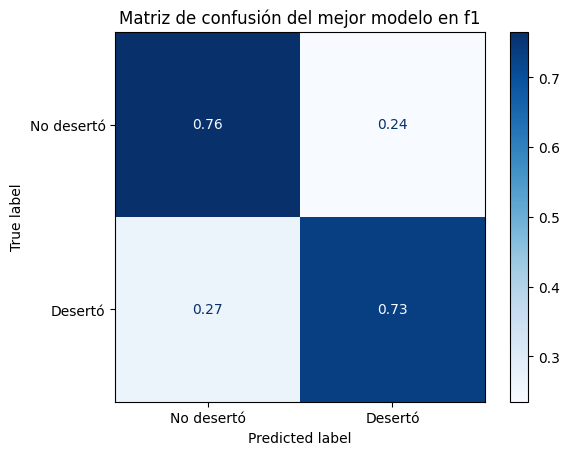

In [70]:
# pipeline con imputer, scaler y encoder
pipeline = Pipeline([
    ('imputer', im.make_imputer()),
    ('scaler', sc.make_scaler()),
    ('encoder', enc.make_encoder()),
    ('classifier', BaggingClassifier(
                        estimator=LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', solver='liblinear'),
                        n_estimators=22))
]).set_output(transform='pandas')

model = pipeline.fit(X_train, y_train)
print(f"Mejor modelo: \n{model}\n----")
y_pred = model.predict(X_test)
print(f'Recall: {recall_score(y_test, y_pred)}.')
print(f'Precision: {precision_score(y_test, y_pred)}.')
print(f'F1 score: {f1_score(y_test, y_pred)}.')
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['No desertó', 'Desertó']

cmd = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true', cmap=plt.cm.Blues, labels=[0.0, 1.0], display_labels=class_names)
plt.title(f'Matriz de confusión del mejor modelo en f1')
plt.savefig(fname=os.path.join(repo_path, 'figures/conf_matrix.png'))

# Atributos de mayor importancia

In [71]:
col_names = model.named_steps['encoder'].get_feature_names_out()
coefs = pd.concat([pd.DataFrame(lr.coef_, columns=col_names) for lr in model.named_steps['classifier'].estimators_]).reset_index()
coefs.index += 1
coefs.index.name = 'n_estimator'

In [72]:
coefs

,index,REGION_40,REGION_41,REGION_42,REGION_43,REGION_44,CH03_2.0,CH03_3.0,CH03_4.0,CH03_5.0,...,JEFA_MUJER,HOGAR_MONOP,NBI_COBERTURA_PREVISIONAL,NBI_DIFLABORAL,NBI_HACINAMIENTO,NBI_SANITARIA,NBI_TENENCIA,NBI_TRABAJO_PRECARIO,NBI_VIVIENDA,NBI_ZONA_VULNERABLE
n_estimator,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0,0.0,0.0,0.0,-0.032398,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0,0.0,0.0,0.0,-0.023744,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0,0.0,0.0,0.0,0.000000,0.0,0.088971,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [73]:
no_zero = coefs.loc[:, (coefs != 0).any()]
no_zero.columns

Index(['REGION_43', 'CH03_2.0', 'CH07_5.0', 'ESTADO_3.0', 'ESTADO_conyuge_1.0',
       'ESTADO_conyuge_3.0', 'AGLOMERADO', 'CH06', 'IV2', 'II2', 'IX_TOT',
       'IX_MEN10', 'CH06_jefx', 'ratio_ocupados', 'CH08', 'V11', 'V12', 'II1',
       'DECCFR', 'MAS_500', 'CH04', 'NIVEL_ED', 'IV4', 'IV11', 'II4_2',
       'II4_3', 'II8', 'NIVEL_ED_jefx', 'CONYUGE_TRABAJA',
       'NBI_TRABAJO_PRECARIO'],
      dtype='object')

In [74]:
no_zero

,REGION_43,CH03_2.0,CH07_5.0,ESTADO_3.0,ESTADO_conyuge_1.0,ESTADO_conyuge_3.0,AGLOMERADO,CH06,IV2,II2,...,CH04,NIVEL_ED,IV4,IV11,II4_2,II4_3,II8,NIVEL_ED_jefx,CONYUGE_TRABAJA,NBI_TRABAJO_PRECARIO
n_estimator,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,-0.022521,-0.517237,0.000000,0.000000,0.000000,0.665912,-0.009344,0.000000,...,0.038293,0.071210,0.006546,0.000000,0.000000,0.000000,0.024144,-0.057508,0.000000,0.000000
2,-0.032398,0.000000,-0.018271,-0.626548,0.000000,0.000000,0.000000,0.664405,0.000000,-0.010291,...,0.085711,0.085826,-0.024362,0.000000,0.000000,0.000000,0.063147,-0.036919,0.000000,0.000000
3,-0.023744,0.000000,0.000000,-0.670531,0.000000,0.000000,0.000000,0.619402,0.000000,0.000000,...,0.000000,0.074185,0.000000,0.000000,0.000000,0.000000,0.013752,-0.039776,0.000000,0.000000
4,0.000000,0.000000,-0.004285,-0.423892,0.000000,0.000689,0.000000,0.765004,0.000000,-0.049489,...,0.080670,0.078630,0.000000,0.000000,0.000000,0.000000,0.099796,-0.098192,0.000000,0.000000
5,0.000000,0.000000,0.000000,-0.643233,0.000000,0.000000,0.000000,0.694187,0.000000,0.000000,...,0.028901,0.080369,0.000000,0.000000,0.000000,0.000000,0.108506,-0.061689,0.000000,0.000000
6,0.000000,0.088971,0.000000,-0.699011,0.000000,0.000000,0.000334,0.616224,0.000000,0.000000,...,0.030603,0.111011,-0.005772,0.000000,0.000000,0.000000,0.000000,-0.044146,0.000000,0.000000
7,0.000000,0.000000,0.000000,-0.526015,0.000000,0.000000,0.000000,0.673476,-0.034641,0.000000,...,0.005309,0.110386,0.007679,0.000000,0.000000,0.000000,0.117032,-0.117791,0.000000,0.000000
8,0.000000,0.000000,0.000000,-0.572303,-0.070363,0.000000,0.013143,0.639879,0.000000,0.000000,...,0.047738,0.065211,0.000000,0.041167,-0.030006,0.000000,0.063836,-0.062957,-0.001192,0.000000
9,0.000000,0.000000,-0.029466,-0.522862,0.000000,0.000000,0.041083,0.697012,-0.038041,0.000000,...,0.087966,0.051624,0.000000,0.000000,-0.011537,0.000000,0.102061,-0.045348,0.000000,0.000000


In [75]:
magnitude = pd.DataFrame(no_zero.mean() / no_zero.std()).reset_index()
magnitude.rename({'index': 'atributo', 0: 'value'}, axis=1, inplace=True)

In [76]:
zero = coefs.loc[:, (coefs == 0).all()]
zero.columns

Index(['index', 'REGION_40', 'REGION_41', 'REGION_42', 'REGION_44', 'CH03_3.0',
       'CH03_4.0', 'CH03_5.0', 'CH03_6.0', 'CH03_7.0', 'CH03_8.0', 'CH03_9.0',
       'CH03_10.0', 'CH07_2.0', 'CH07_3.0', 'CH07_4.0', 'CH15_2.0', 'CH15_3.0',
       'CH15_4.0', 'CH15_5.0', 'CH09_2.0', 'CH16_1.0', 'CH16_2.0', 'CH16_3.0',
       'CH16_4.0', 'CH16_5.0', 'ESTADO_2.0', 'ESTADO_jefx_1.0',
       'ESTADO_jefx_2.0', 'ESTADO_jefx_3.0', 'ESTADO_conyuge_2.0',
       'ESTADO_conyuge_4.0', 'PP02E_2.0', 'PP02E_3.0', 'PP02E_4.0',
       'PP02E_5.0', 'CH11', 'V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V13',
       'V14', 'PP07I_jefx', 'CH10', 'PP02H', 'servicio_domestico', 'IV1',
       'IV3', 'IV5', 'IV6', 'IV7', 'IV9', 'IV12_2', 'II3', 'II4_1', 'II9',
       'V21', 'V22', 'APORTES_JUBILATORIOS_jefx', 'PP04B1_jefx', 'JEFA_MUJER',
       'HOGAR_MONOP', 'NBI_COBERTURA_PREVISIONAL', 'NBI_DIFLABORAL',
       'NBI_HACINAMIENTO', 'NBI_SANITARIA', 'NBI_TENENCIA', 'NBI_VIVIENDA',
       'NBI_ZONA_VULNERABLE'],
  

<Axes: xlabel='atributo'>

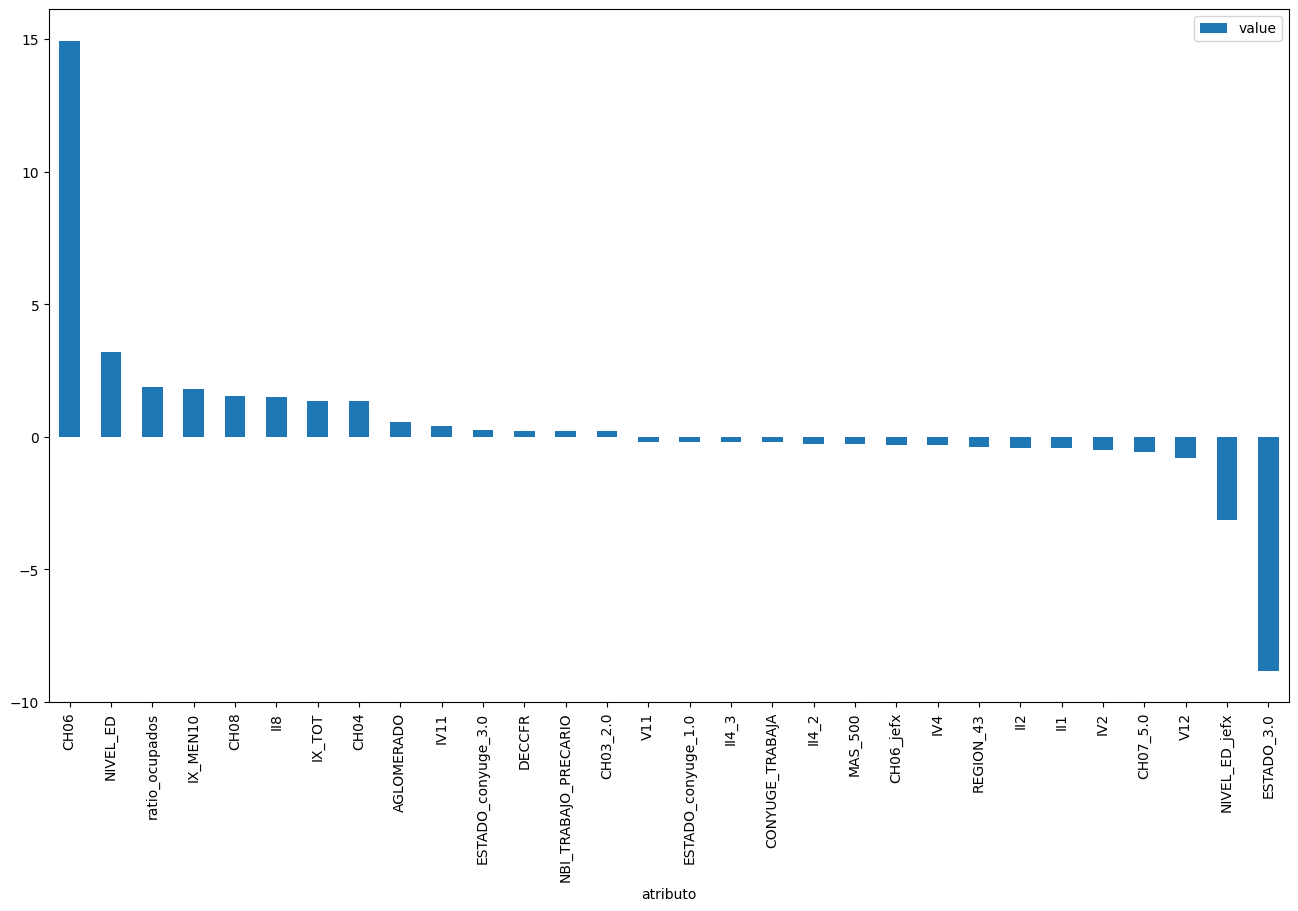

In [77]:
magnitude.sort_values(by='value', ascending=False).plot(kind='bar', x='atributo', y='value', figsize=(16,9))

## Reentrenamiento en dimensión reducida

In [78]:
no_zero_cols = [
    'REGION', 'CH03', 'CH07', 'ESTADO', 'ESTADO_conyuge', 'AGLOMERADO', 'CH06', 
    'IV2', 'II2', 'IX_TOT', 'IX_MEN10', 'CH06_jefx', 'ratio_ocupados', 'CH08', 
    'V2', 'V5', 'V12', 'II1', 'DECCFR', 'MAS_500', 'CH04', 'NIVEL_ED', 'IV3', 
    'IV4', 'IV11', 'II4_2', 'II4_3', 'II8', 'NIVEL_ED_jefx', 'CONYUGE_TRABAJA',
    'NBI_TRABAJO_PRECARIO'
]
X_train_reduced = X_train.loc[:, X_train.columns.isin(no_zero_cols)]

In [88]:
cols9 = ['CH07', 'CH08', 'V2', 'V5', 'V12']
cols99 = ['IV2', 'II1']
col12 = ['DECCFR']
cat_cols = ['REGION', 'CH03', 'CH07', 'ESTADO', 'ESTADO_conyuge']

Mejor modelo: 
Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer-1',
                                                  KNNImputer(missing_values=9.0,
                                                             n_neighbors=1),
                                                  ['CH07', 'CH08', 'CH11', 'V1',
                                                   'V2', 'V3', 'V5', 'V6', 'V7',
                                                   'V8', 'V11', 'V12', 'V13',
                                                   'V14', 'PP07I_jefx']),
                                                 ('knnimputer-2',
                                                  KNNImputer(missing_values=99.0,
                                                             n_neighbors=1),
                                                  ['IV2', 'II1']),
                                                 ('knnimputer-3',
 

Text(0.5, 1.0, 'Matriz de confusión del mejor modelo en f1')

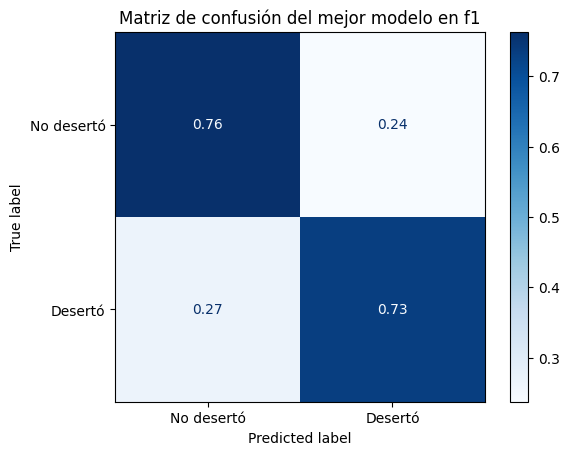

In [89]:
# pipeline con imputer, scaler y encoder
pipeline_r = Pipeline([
    ('imputer', im.make_imputer(c9=cols9, c99=cols99, c12=col12)),
    ('scaler', sc.make_scaler()),
    ('encoder', enc.make_encoder(cols=cat_cols)),
    ('classifier', BaggingClassifier(
                        estimator=LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', solver='liblinear'),
                        n_estimators=22))
]).set_output(transform='pandas')

model_r = pipeline_r.fit(X_train_reduced, y_train)
print(f"Mejor modelo: \n{model}\n----")
y_pred_r = model_r.predict(X_test[no_zero_cols])
print(f'Recall: {recall_score(y_test, y_pred_r)}.')
print(f'Precision: {precision_score(y_test, y_pred_r)}.')
print(f'F1 score: {f1_score(y_test, y_pred_r)}.')
conf_matrix = confusion_matrix(y_test, y_pred_r)
class_names = ['No desertó', 'Desertó']

cmd = ConfusionMatrixDisplay.from_estimator(model_r, X_test[no_zero_cols], y_test, normalize='true', cmap=plt.cm.Blues, labels=[0.0, 1.0], display_labels=class_names)
plt.title(f'Matriz de confusión del mejor modelo en f1')
# plt.savefig(fname=os.path.join(repo_path, 'figures/conf_matrix.png'))